In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Parameter definieren

In [1]:
rows = 64
cols = 64
num_pixels = rows * cols

num_angles = 30      # Anzahl der Winkel
num_rays_per_angle = 100   # Anzahl paralleler Strahlen pro Winkel
I0 = 100.0  

### Phantom Bild

- erstellte als Phantom Bild ein Kreis, dass als Untersuchungsobjekt dient
- Die Pixel Werte sollen nun bestimmt werden

In [3]:
def phantom_bild(rows: int, cols: int) -> np.ndarray:
    phantom = np.zeros((rows, cols))
    yy, xx = np.indices((rows, cols))
    cy, cx = rows//2, cols//2
    r = min(rows, cols)//4
    # Kreis in der Mitte
    mask_circle = (xx - cx)**2 + (yy - cy)**2 <= r**2
    phantom[mask_circle] = 5.0
    # Rechteck oben links
    phantom[10:20, 10:25] = 3.0
    return phantom


### Strahlenabsorption

- Die Funktion implementiert die Abschwächung der Röntgenstrahlen die durch den Körper gehen während der CT-Untersuchung

- Diese Abschwächung wird als Summe aller Pixelwerte entlang des Strahlweges implementiert 

In [5]:
def line_pixels_detection(start, end, rows, cols):
    y0, x0 = start
    y1, x1 = end

    dy = abs(y1 - y0)
    dx = abs(x1 - x0)
    sy = 1 if y0 < y1 else -1
    sx = 1 if x0 < x1 else -1
    err = dx - dy

    pixels = []
    x, y = x0, y0
    while True:
        if 0 <= y < rows and 0 <= x < cols:
            pixels.append((y,x))
        if x == x1 and y == y1:
            break
        e2 = 2*err
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy
    return pixels

### Untersuchung und Messung

- Daten werden erzeugt

In [4]:
angles = np.linspace(0, 180, num_angles, endpoint=False)
A_rows = []
b_vec = []

cy, cx = rows/2.0, cols/2.0
max_offset = max(rows, cols)/2.0
offsets = np.linspace(-max_offset, max_offset, num_rays_per_angle)
true_image = phantom_bild(rows, cols)
true_x = true_image.flatten()

In [7]:
for alpha_deg in angles:
    # Strahl erzeugen in Bogenmaß alpha
    alpha = np.deg2rad(alpha_deg)
    
    # Richtung des Strahls bestimmen: (dx, dy) = (cos(alpha), sin(alpha))
    dx = np.cos(alpha)
    dy = np.sin(alpha) 
    
    # Normalenvektor (90° Versatz) bestimmen: (nx, ny) = (-sin(alpha), cos(alpha))
    nx = -np.sin(alpha)
    ny = np.cos(alpha)

    for t in offsets:
        # Px0, Py0 ist ein Punkt auf der Strahlenlinie, der um t in Richtung des Normalenvektors verschoben ist
        Px0 = cx + t*nx
        Py0 = cy + t*ny

        # Wir wählen einen großen Bereich in lam_min und lam_max, um sicherzugehen,
        # dass die gerade Linie das Bildfeld komplett durchquert.
        lam_min = -max(rows, cols)
        lam_max = max(rows, cols)

        Xstart = Px0 + lam_min*dx
        Ystart = Py0 + lam_min*dy
        Xend = Px0 + lam_max*dx
        Yend = Py0 + lam_max*dy

        start_pixel = (int(round(Ystart)), int(round(Xstart)))
        end_pixel   = (int(round(Yend)),   int(round(Xend)))

        # Bestimme die Pixel auf diesem Strahl
        ray_pixels = line_pixels_detection(start_pixel, end_pixel, rows, cols)

        # Berechne die Abschwächung: Summe der Pixelwerte auf dem Strahl
        true_attenuation = sum(true_image[y,x] for (y,x) in ray_pixels)
        # Ausgangsintensität
        I_out = I0 - true_attenuation

        # sum(x_j) = I0 - I_out
        # Hier entsteht eine Gleichung: Für alle Pixel auf dem Strahl ist der Koeffizient 1, sonst 0.
        row = np.zeros(num_pixels)
        for (y,x) in ray_pixels:
            row[y*cols + x] = 1.0

        A_rows.append(row)
        b_vec.append(I0 - I_out)


### LGS wird erzeugt

In [8]:
A = np.array(A_rows)
b = np.array(b_vec)

### LGS lösen

In [9]:
X, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

### Körper Bild Rekonstruieren

In [10]:
reconstructed_image = X.reshape((rows, cols))

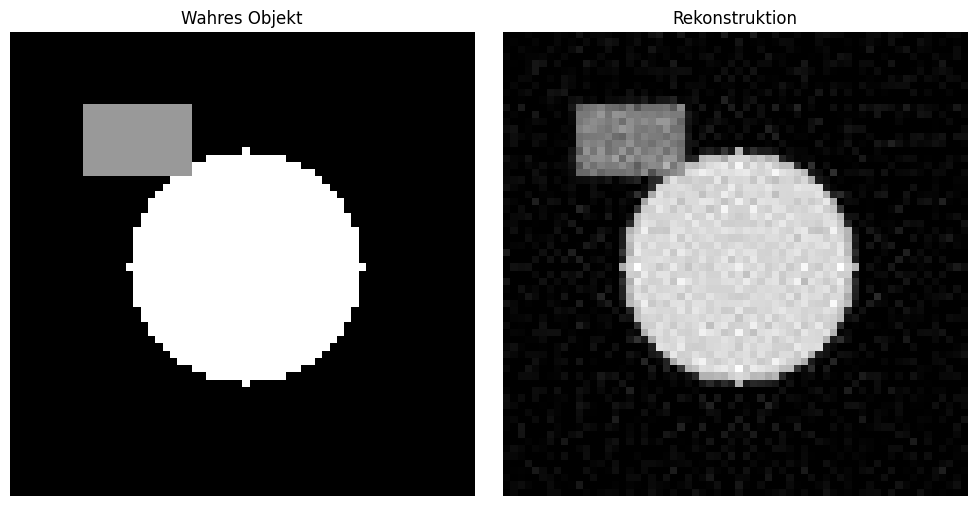

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(true_image, cmap='gray', vmin=0, vmax=np.max(true_image))
axs[0].set_title('Wahres Objekt')
axs[1].imshow(reconstructed_image, cmap='gray', vmin=0, vmax=np.max(reconstructed_image))
axs[1].set_title('Rekonstruktion')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()